In [155]:
import nltk
import numpy as np
from sklearn.utils import shuffle
from nltk.corpus import stopwords, brown
from torch.utils.data import TensorDataset, DataLoader
nltk.download('stopwords')
nltk.download('brown')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from matplotlib import pyplot as plt


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/dotronghiep/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package brown to
[nltk_data]     /home/dotronghiep/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/dotronghiep/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [156]:
import pandas as pd

df = pd.read_csv('/home/dotronghiep/Documents/Datasets/Social_Listening/DataLabel.csv', header=None)
df.head(10)

,0,1,2
0,1,0,impossible to stop basically means russia is n...
1,2,0,indeed. may russia soil then selves in terror ...
2,3,0,"goodnight family, thanks to everyone for your ..."
3,4,0,keep adding more sanctionsfastest way to get r...
4,5,0,russia does not get to rape ukraine in order t...
5,6,1,its already done de facto. east ukraineand cri...
6,7,1,russia takes most of sievierodonetsk city in e...
7,8,0,biden says us to send ukraine 'advanced rocket...
8,9,1,just in - biden us to send ukraine advanced ro...
9,10,0,why do you suppose i do not understand that. i...


In [157]:
X_row = df.iloc[:, 2].values
y = df.iloc[:, 1].values

In [158]:
# Xác định số lượng mẫu của mỗi lớp
class_0_count = np.sum(y == 0)
class_1_count = np.sum(y == 1)
print(class_0_count,class_1_count)

4108 1663


In [159]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_row, y, test_size=0.2, random_state=42, stratify=y)

# Train the model

In [160]:
print(len(X_train))

4616


In [161]:
print(len(y_train))

4616


In [162]:
# lấy danh sách stopword
stop = set(stopwords.words('english'))
# stop = ()
brown_words = set(word for word in brown.words() if word.lower() not in stop)|{"biden",
                                                                               "ukraine","kiev","kyiv","zelensky", "ukrainian", "ukrainians",
                                                                               "putin","kremlin", "russia", "russian", "russians",
                                                                               "not", "no", "nor", "against", "never", "nobody", "none", "nowhere"}

lemmatizer = WordNetLemmatizer()
tokenizer = RegexpTokenizer(r'[a-zA-Z]+')

In [163]:
def lemma(text):
    words = tokenizer.tokenize(text)
    cleaned_words = [lemmatizer.lemmatize(word, pos='v') for word in words if word in brown_words]
    return cleaned_words


# Loại bỏ stop words từ mỗi văn bản trong danh sách X
X_cleaned = [lemma(text) for text in X_train]


In [164]:
X_cleaned[:10]

[['ukraine', 'every', 'right', 'attack', 'russia', 'point'],
 ['real', 'men', 'defend', 'country', 'people', 'respect'],
 ['well',
  'honest',
  'russian',
  'visit',
  'board',
  'quite',
  'time',
  'russia',
  'start',
  'military',
  'build',
  'ukraine',
  'border',
  'last',
  'year',
  'call',
  'journalist'],
 ['poor',
  'russian',
  'regime',
  'world',
  'say',
  'no',
  'brutal',
  'invasion',
  'play',
  'victim',
  'get',
  'ukraine'],
 ['definitely', 'arm', 'ukraine', 'teeth', 'keep', 'russia'],
 ['legitimate',
  'security',
  'concern',
  'already',
  'countries',
  'members',
  'military',
  'base',
  'nuclear',
  'capability',
  'wipe',
  'russia',
  'map',
  'ukraine',
  'make',
  'zero',
  'difference',
  'putin',
  'know',
  'join',
  'could',
  'not',
  'invade',
  'point'],
 ['ukraine',
  'shut',
  'listen',
  'russia',
  'like',
  'shut',
  'listen',
  'us',
  'argue',
  'otherwise',
  'accept',
  'kind',
  'absurd',
  'prevalent',
  'among',
  'riddle',
  'cat',

In [165]:
import torch
import gensim.downloader as api
import csv
from gensim.models.word2vec import Word2Vec

In [166]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [167]:
max_length = max(len(sentence) for sentence in X_cleaned)
max_length

36

In [168]:
model = Word2Vec(X_cleaned, 
                 vector_size=100, 
                 window=11, 
                 min_count=5, 
                 workers=8, 
                 epochs=50)
vocabulary = model.wv.index_to_key
print(f"Vocabulary size: {len(vocabulary)}")

Vocabulary size: 1754


In [219]:
# Tìm từ gần nhất 
similar_words = model.wv.most_similar("putin")
for word, score in similar_words:
    print(f"{word}: {score:.4f}")

monster: 0.4678
weak: 0.4245
century: 0.3970
hostile: 0.3895
madness: 0.3772
bloodshed: 0.3588
threats: 0.3571
horror: 0.3528
hot: 0.3522
bully: 0.3489


In [170]:
import numpy as np
import torch
from torch.nn.utils.rnn import pad_sequence

def vectorize(X, y, model=model):
    X_vectors = []
    y_vectors = []
    # Chuyển từng từ trong mỗi câu thành vector biểu diễn và thêm padding
    for sentence, label in zip(X, y):
        # Tạo một danh sách để lưu trữ các vector biểu diễn của các từ trong câu
        if sentence == []:
            continue
        sentence_vectors = []
        for word in sentence:
            # Kiểm tra xem từ đó có trong từ vựng của mô hình Word2Vec hay không
            if word in model.wv:
                word_vector = model.wv[word]
                sentence_vectors.append(word_vector)
            else:
                # Nếu từ không có trong từ vựng, bạn có thể sử dụng một vector thay thế hoặc bỏ qua nó
                # Ví dụ: word_vector = np.zeros((vector_size,))
                pass

        # Thêm padding cho câu để độ dài của mỗi câu là 35
        while len(sentence_vectors) < 35:
            sentence_vectors.append(np.zeros((100,)))  # Sử dụng vector zeros cho padding

        # Chuyển danh sách các vector thành một tensor
        sentence_tensor = torch.tensor(sentence_vectors)
        # Thêm câu đã được padding vào danh sách X_vectors
        X_vectors.append(sentence_tensor)
        y_vectors.append(label)


    # Chuyển danh sách X_vectors thành một tensor
    X_padded = np.array(X_vectors)
    y_padded = np.array(y_vectors)
    return X_padded, y_padded

# In ra kích thước của X_padded
X_input, y_input = vectorize(X_cleaned, y_train)
print(X_input.shape)
print(y_input.shape)


(4613, 35, 100)
(4613,)


In [208]:
import torch
import torch.nn as nn
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTMClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, 64)
        self.fc2 = nn.Linear(64, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, x):
        # Khởi tạo hidden state và cell state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # Đưa đầu vào qua LSTM
        out, _ = self.lstm(x, (h0, c0))
        
        # Lấy output của lớp cuối cùng
        out = self.fc1(out[:, -1, :])
        out = self.dropout(out)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.softmax(out)
        return out

# Định nghĩa các siêu tham số
input_size = 100  # Kích thước của vectơ biểu diễn từ
hidden_size = 128  # Kích thước của hidden state trong LSTM
num_layers = 2  # Số lớp LSTM xếp chồng lên nhau
num_classes = 2  # Số lớp đầu ra
num_epochs = 100  # Số epoch
lr = 0.0001
batch_size = 256

Epoch 5, Loss validate: 0.6889326572418213
Accuracy: 0.7118093174431203
Precision: 0.0
Recall: 0.0
F1 Score: 0.0


/home/dotronghiep/anaconda3/envs/NLP/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 10, Loss validate: 0.7099864482879639
Accuracy: 0.2979414951245937
Precision: 0.2905701754385965
Recall: 0.9962406015037594
F1 Score: 0.44991511035653653
Epoch 15, Loss validate: 0.6956946849822998
Accuracy: 0.6392199349945829
Precision: 0.39755351681957185
Recall: 0.48872180451127817
F1 Score: 0.4384485666104553
Epoch 20, Loss validate: 0.6620453000068665
Accuracy: 0.6554712892741061
Precision: 0.40225563909774437
Recall: 0.40225563909774437
F1 Score: 0.40225563909774437
Epoch 25, Loss validate: 0.6731361746788025
Accuracy: 0.6489707475622969
Precision: 0.4
Recall: 0.43609022556390975
F1 Score: 0.4172661870503597
Epoch 30, Loss validate: 0.6737052798271179
Accuracy: 0.6554712892741061
Precision: 0.40441176470588236
Recall: 0.41353383458646614
F1 Score: 0.40892193308550184
Epoch 35, Loss validate: 0.665913462638855
Accuracy: 0.6619718309859155
Precision: 0.4115384615384615
Recall: 0.40225563909774437
F1 Score: 0.40684410646387825
Epoch 40, Loss validate: 0.670671284198761
Accurac

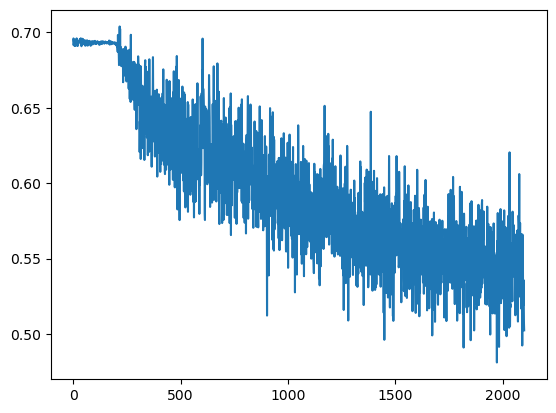

In [209]:
# Khởi tạo mô hình
lstm = LSTMClassifier(input_size, hidden_size, num_layers, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lstm.parameters(), lr=lr)
lstm.to(device)

X_train, X_valid, y_train, y_valid = train_test_split(X_input, y_input, test_size=0.2, random_state=42, stratify=y_input)

# Xác định số lượng mẫu của mỗi lớp
class_0_count = np.sum(y_train == 0)
class_1_count = np.sum(y_train == 1)
# Tính toán số lượng mẫu cần thêm vào mỗi lớp để làm cho số lượng mẫu của hai lớp bằng nhau
sample_diff = abs(class_0_count - class_1_count)
samples_to_add = max(class_0_count, class_1_count) - min(class_0_count, class_1_count)

# Lấy mẫu ngẫu nhiên từ các mẫu hiện có trong lớp ít mẫu để tạo ra số lượng mẫu cần thiết và thêm vào tập train
if class_0_count < class_1_count:
    X_train_class_0 = X_train[y_train == 0]
    y_train_class_0 = y_train[y_train == 0]
    additional_indices = np.random.choice(range(class_0_count), samples_to_add)
    X_train_additional = X_train_class_0[additional_indices]
    y_train_additional = y_train_class_0[additional_indices]
    X_train = np.concatenate((X_train, X_train_additional))
    y_train = np.concatenate((y_train, y_train_additional))
else:
    X_train_class_1 = X_train[y_train == 1]
    y_train_class_1 = y_train[y_train == 1]
    additional_indices = np.random.choice(range(class_1_count), samples_to_add)
    X_train_additional = X_train_class_1[additional_indices]
    y_train_additional = y_train_class_1[additional_indices]
    X_train = np.concatenate((X_train, X_train_additional))
    y_train = np.concatenate((y_train, y_train_additional))

# Trộn lại dữ liệu để đảm bảo tính ngẫu nhiên
X_train, y_train = shuffle(X_train, y_train, random_state=42)

X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
X_valid = torch.tensor(X_valid, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train).to(device)
y_valid = torch.tensor(y_valid).to(device)

# Tạo DataLoader cho dữ liệu train và validation
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

valid_dataset = TensorDataset(X_valid, y_valid)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

# Vòng lặp huấn luyện
losses = []
for epoch in range(1, num_epochs + 1):
    # Huấn luyện
    lstm.train()
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = lstm(X_batch)
        loss = criterion(outputs, y_batch)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()

    # In ra loss sau mỗi 5 eclass_0_count = np.sum(predicted_labels == 0)
    if epoch % 5 == 0:

        # Đánh giá mô hình trên tập validation
        lstm.eval()
        with torch.no_grad():
            # for X_batch, y_batch in valid_loader:
            outputs = lstm(X_valid)
            loss = criterion(outputs, y_valid)
            print(f"Epoch {epoch}, Loss validate: {loss.item()}")

        _, predicted = torch.max(outputs, 1)
        predicted_labels = predicted.cpu().numpy()
        true_labels = y_valid.cpu().numpy()
        accuracy = accuracy_score(true_labels, predicted_labels)
        precision = precision_score(true_labels, predicted_labels)
        recall = recall_score(true_labels, predicted_labels)
        f1 = f1_score(true_labels, predicted_labels)

        print("Accuracy:", accuracy)
        print("Precision:", precision)
        print("Recall:", recall)
        print("F1 Score:", f1)

        print("=========================================")
plt.plot(losses)

In [201]:
class_0_count = np.sum(predicted_labels == 0)
class_1_count = np.sum(predicted_labels == 1)
print(class_0_count,class_1_count)

711 212


In [203]:
class_0_count = np.sum(true_labels == 0)
class_1_count = np.sum(true_labels == 1)
print(class_0_count,class_1_count)

657 266
